In [4]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from ultralytics import solutions  # kept for compatibility

# -----------------------------
# numerically-safe activations
# -----------------------------
def safe_softplus(z):
    z = np.asarray(z, dtype=np.float64)
    return np.log1p(np.exp(-np.abs(z))) + np.maximum(z, 0.0)

def safe_sigmoid(z):
    z = np.asarray(z, dtype=np.float64)
    out = np.empty_like(z, dtype=np.float64)
    pos = z >= 0
    out[pos]  = 1.0 / (1.0 + np.exp(-z[pos]))
    e = np.exp(z[~pos])
    out[~pos] = e / (1.0 + e)
    return out

# -----------------------------
# geometry helpers (center-line crossing)
# -----------------------------
def _orient(a, b, c):
    return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])

def _line_side(p, a, b):
    s = _orient(a, b, p)
    return 0 if s == 0 else (1 if s > 0 else -1)

def _segments_intersect(p1, p2, q1, q2):
    o1 = _orient(p1, p2, q1)
    o2 = _orient(p1, p2, q2)
    o3 = _orient(q1, q2, p1)
    o4 = _orient(q1, q2, p2)
    if (o1 == 0 and o2 == 0 and o3 == 0 and o4 == 0):
        return (min(p1[0], p2[0]) <= max(q1[0], q2[0]) and
                min(q1[0], q2[0]) <= max(p1[0], p2[0]) and
                min(p1[1], p2[1]) <= max(q1[1], q2[1]) and
                min(q1[1], q2[1]) <= max(p1[1], p2[1]))
    return (o1 == 0 or o2 == 0 or np.sign(o1) != np.sign(o2)) and \
           (o3 == 0 or o4 == 0 or np.sign(o3) != np.sign(o4))


# -----------------------------
# feature extractor (vector)
#   - bbox area (normalized)
#   - aspect ratio (w/h)
#   - squareness = min(w,h)/max(w,h)
#   - yellow metrics in HSV:
#       * fraction of yellow pixels
#       * mean S within yellow
#       * mean V within yellow
# -----------------------------
import utils.get_bounding_box_features as bbf
import utils.yellow_masks as ym
def get_features(roi_bgr: np.ndarray) -> np.ndarray:
    if roi_bgr.size == 0:
        return np.zeros(6, dtype=np.float64)
    h, w = roi_bgr.shape[:2]
    area = float(h * w)
    if area <= 1:
        return np.zeros(6, dtype=np.float64)

    # geometry
    area_norm = area / 1e4                      # rough normalization scale
    aspect = (w / max(h, 1.0))
    square = min(w, h) / max(w, h)

    # color (HSV)
    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = hsv[..., 0], hsv[..., 1], hsv[..., 2]

    # yellow mask (OpenCV H in [0,179]): approx 20-40°, adjust if needed
    yellow_lo, yellow_hi = 20, 40
    S_lo, V_lo = 70, 100  # avoid very desaturated/dim pixels
    ymask = (H >= yellow_lo) & (H <= yellow_hi) & (S >= S_lo) & (V >= V_lo)

    y_count = float(np.count_nonzero(ymask))
    y_frac  = y_count / area
    if y_count > 0:
        y_mean_s = float(S[ymask].mean()) / 255.0
        y_mean_v = float(V[ymask].mean()) / 255.0
    else:
        y_mean_s = 0.0
        y_mean_v = 0.0

    # overall brightness can still help a bit
    v_mean = float(V.mean()) / 255.0
    
    box = ym.get_yellow_mask(img=roi_bgr, normalize=True)
    
    area = bbf.get_area(box)  # Total area of the bounding box
    mean_yellow = bbf.get_mean_yellow(box)  # Mean temperature in the bounding box
    pthresh_o = bbf.get_pixels_over_threshold(box, 0.8)  # Standard deviation of temperatures
    pthresh_u = bbf.get_pixels_under_threshold(box, 0.8)  # Variance of temperatures
    y_range = bbf.get_yellow_range(box)  # Range of temperatures
    y_std = bbf.get_yellow_std(box)  # Relative count of pixels over 30C
    y_var = bbf.get_yellow_variance(box)  # Relative count of pixels under 30C
    mdft = bbf.get_mean_distance_from_threshold(box, threshold=.8)  # Mean distance from 30C
    asp_rat = bbf.get_aspect_ratio(box)  # Aspect ratio of the bounding box

    return np.array([ area_norm, aspect, square, y_frac, y_mean_s, y_mean_v, v_mean, #], dtype=np.float64)
                     area, mean_yellow, pthresh_o, pthresh_u, y_range, y_std, y_var, mdft, asp_rat], dtype=np.float64)

import numpy as np
import cv2
import utils.get_bounding_box_features as bbf
import utils.yellow_masks as ym

def _safe_div(a, b, default=0.0):
    return float(a) / float(b) if b not in (0, 0.0) else float(default)

def _entropy_from_values(vals, bins=32):
    if vals.size == 0:
        return 0.0
    hist, _ = np.histogram(vals, bins=bins, range=(0, 255), density=False)
    p = hist.astype(np.float64)
    Z = p.sum()
    if Z <= 0:
        return 0.0
    p /= Z
    p = p[p > 0]
    return float(-(p * np.log2(p)).sum())

def get_features2(roi_bgr: np.ndarray) -> np.ndarray:
    """
    Feature vector (length 32) summarizing yellow coverage, topology, texture,
    and spatial mass within a chick bounding box (BGR ROI).
    Returns zeros if ROI is empty or degenerate.
    """
    # -------------------- safety checks --------------------
    if roi_bgr is None or roi_bgr.size == 0:
        return np.zeros(32, dtype=np.float64)

    h, w = roi_bgr.shape[:2]
    area_bbox = int(h) * int(w)
    if area_bbox <= 1:
        return np.zeros(32, dtype=np.float64)

    # -------------------- geometry --------------------
    area_norm = area_bbox / 1e4  # rough scale for stability across ROI sizes
    aspect = _safe_div(w, max(h, 1.0), 0.0)
    squareness = _safe_div(min(w, h), max(w, h), 0.0)

    # -------------------- color masks (HSV) --------------------
    hsv = cv2.cvtColor(roi_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = hsv[..., 0], hsv[..., 1], hsv[..., 2]

    # "Yellow" band in OpenCV HSV: H in [20, 40], with S and V floors to avoid dull/dark
    yellow_lo, yellow_hi = 20, 40
    S_lo, V_lo = 70, 100
    ymask = (H >= yellow_lo) & (H <= yellow_hi) & (S >= S_lo) & (V >= V_lo)

    y_count = int(np.count_nonzero(ymask))
    y_frac = _safe_div(y_count, area_bbox, 0.0)

    # overall brightness (helps disambiguate lighting)
    v_mean_overall = float(V.mean()) / 255.0

    # stats INSIDE yellow only
    if y_count > 0:
        S_y = S[ymask].astype(np.float64)
        V_y = V[ymask].astype(np.float64)

        y_mean_s = float(S_y.mean()) / 255.0
        y_mean_v = float(V_y.mean()) / 255.0

        y_std_s = float(S_y.std(ddof=0)) / 255.0
        y_std_v = float(V_y.std(ddof=0)) / 255.0

        # Percentiles of V (contrast/illumination robustness)
        y_p10_v = float(np.percentile(V_y, 10)) / 255.0
        y_p50_v = float(np.percentile(V_y, 50)) / 255.0
        y_p90_v = float(np.percentile(V_y, 90)) / 255.0

        # Entropies (texture richness of S and V within yellow)
        y_entropy_s = _entropy_from_values(S_y, bins=32)
        y_entropy_v = _entropy_from_values(V_y, bins=32)
    else:
        y_mean_s = y_mean_v = 0.0
        y_std_s = y_std_v = 0.0
        y_p10_v = y_p50_v = y_p90_v = 0.0
        y_entropy_s = y_entropy_v = 0.0

    # -------------------- topology / shape on yellow mask --------------------
    # Convert mask to uint8 for contour ops
    ymask_u8 = ymask.astype(np.uint8) * 255

    comp_count = 0
    largest_comp_frac = 0.0
    perimeter_norm = 0.0
    solidity = 0.0
    eccentricity = 0.0
    orientation = 0.0  # principal axis angle normalized by pi to [-1, 1]
    cx_norm = 0.0
    cy_norm = 0.0

    if y_count > 0:
        contours, _ = cv2.findContours(ymask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        comp_count = len(contours)

        # Areas & perimeters
        cont_areas = [cv2.contourArea(c) for c in contours] if contours else [0.0]
        total_perimeter = sum(cv2.arcLength(c, True) for c in contours) if contours else 0.0
        largest_area = max(cont_areas) if cont_areas else 0.0

        largest_comp_frac = _safe_div(largest_area, y_count, 0.0)
        perimeter_norm = _safe_div(total_perimeter, np.sqrt(area_bbox), 0.0)  # scale-invariant

        # Solidity = area / convex_hull_area (summed over comps)
        hull_area_sum = 0.0
        for c in contours:
            hull = cv2.convexHull(c)
            hull_area_sum += cv2.contourArea(hull)
        solidity = _safe_div(y_count, hull_area_sum, 0.0)

        # Centroid and PCA-based eccentricity/orientation
        ys, xs = np.nonzero(ymask)
        if xs.size > 1:
            # centroid
            cx = xs.mean()
            cy = ys.mean()
            cx_norm = _safe_div(cx, (w - 1 if w > 1 else 1))
            cy_norm = _safe_div(cy, (h - 1 if h > 1 else 1))

            # covariance of coordinates
            X = np.column_stack((xs - cx, ys - cy)).astype(np.float64)
            C = np.dot(X.T, X) / max(X.shape[0] - 1, 1)
            # eigen-decomposition
            evals, evecs = np.linalg.eigh(C)  # sorted ascending
            l2, l1 = evals[0], evals[1]  # l1 >= l2
            if l1 > 1e-12:
                eccentricity = float(np.sqrt(1.0 - (l2 / l1)))  # [0,1)
                # principal direction is eigenvector of l1
                v = evecs[:, 1]
                angle = float(np.arctan2(v[1], v[0]))  # radians in [-pi, pi]
                orientation = angle / np.pi  # normalize to [-1, 1]
            else:
                eccentricity = 0.0
                orientation = 0.0

    # -------------------- edges / texture within yellow --------------------
    edge_density = 0.0
    sobel_mean = 0.0
    lap_var = 0.0

    if y_count > 0:
        # Use V channel for stable edges under hue shifts
        canny = cv2.Canny(V, 50, 150)
        edge_inside = np.logical_and(canny > 0, ymask)
        edge_density = _safe_div(np.count_nonzero(edge_inside), y_count, 0.0)

        # Sobel gradient magnitude (mean)
        Gx = cv2.Sobel(V, cv2.CV_64F, 1, 0, ksize=3)
        Gy = cv2.Sobel(V, cv2.CV_64F, 0, 1, ksize=3)
        mag = np.hypot(Gx, Gy)
        sobel_mean = float(mag[ymask].mean()) if y_count > 0 else 0.0
        sobel_mean /= 255.0

        # Laplacian focus measure (variance)
        lap = cv2.Laplacian(V, cv2.CV_64F, ksize=3)
        lv = lap[ymask]
        lap_var = float(lv.var()) if lv.size > 0 else 0.0
        # Normalize roughly by (255^2) to keep on [0,1]-ish scale
        lap_var /= (255.0 * 255.0)

    # -------------------- spatial mass distribution (quadrants) --------------------
    q1 = q2 = q3 = q4 = 0.0
    if y_count > 0:
        mid_y = h // 2
        mid_x = w // 2
        # TL, TR, BL, BR
        q1 = _safe_div(np.count_nonzero(ymask[0:mid_y, 0:mid_x]), y_count)
        q2 = _safe_div(np.count_nonzero(ymask[0:mid_y, mid_x:w]), y_count)
        q3 = _safe_div(np.count_nonzero(ymask[mid_y:h, 0:mid_x]), y_count)
        q4 = _safe_div(np.count_nonzero(ymask[mid_y:h, mid_x:w]), y_count)

    # -------------------- keep a few curated, non-redundant bbf/ym features --------------------
    # We use your pipeline for consistency, but drop redundant items:
    # - Drop bbf.get_area (duplicates area/coverage ideas),
    # - Drop pthresh_under, y_std, y_var, asp_rat (covered by ours),
    # - Keep mean_yellow, mdft, and y_range as complementary scalars.
    box = ym.get_yellow_mask(img=roi_bgr, normalize=True)
    mean_yellow = float(bbf.get_mean_yellow(box))
    mdft = float(bbf.get_mean_distance_from_threshold(box, threshold=0.8))
    y_range = float(bbf.get_yellow_range(box))

    # -------------------- assemble final vector (32 dims) --------------------
    feats = np.array([
        # 1–3: geometry
        area_norm, aspect, squareness,
        # 4–7: yellow coverage & brightness
        y_frac, y_mean_s, y_mean_v, v_mean_overall,
        # 8–14: dispersion & entropy inside yellow
        y_std_s, y_std_v, y_p10_v, y_p50_v, y_p90_v, y_entropy_s, y_entropy_v,
        # 15–20: topology/shape
        float(comp_count), largest_comp_frac, perimeter_norm, solidity, eccentricity, orientation,
        # 21–23: edge/texture
        edge_density, sobel_mean, lap_var,
        # 24–29: centroid + quadrants
        cx_norm, cy_norm, q1, q2, q3, q4,
        # 30–32: curated from your bbf/ym
        mean_yellow, mdft, y_range
    ], dtype=np.float64)

    # Sanity: ensure length 32
    if feats.shape[0] != 32:
        out = np.zeros(32, dtype=np.float64)
        n = min(32, feats.shape[0])
        out[:n] = feats[:n]
        return out

    return feats


# -------------------------------------------------------
# vector head, softplus output, grouped loss, calibration
# -------------------------------------------------------
class GroupedSoftplusSGDVector:
    """
    Event output y_i = softplus( w·x_i_std + b ) >= 0
    Loss = Σ_k 0.5 * (Σ_{i∈Ik} y_i - dY_k)^2 + L2
    After training, apply a non-negative scalar calibration α to match mass.
    """
    def __init__(self, lr=3e-3, epochs=800, l2=1e-5, clip=2.0, report_every=25, early_stop_patience=50):
        self.lr = lr
        self.epochs = epochs
        self.l2 = l2
        self.clip = clip
        self.report_every = report_every
        self.early_stop_patience = early_stop_patience

        self.w = None  # (D,)
        self.b = 0.0
        self.mu = None  # (D,)
        self.sigma = None  # (D,)
        self.alpha = 1.0  # final calibration

    def _standardize_fit(self, X):
        self.mu = X.mean(axis=0)
        self.sigma = X.std(axis=0)
        self.sigma[self.sigma < 1e-8] = 1.0
        return (X - self.mu) / self.sigma

    def _standardize_apply(self, X):
        return (X - self.mu) / self.sigma

    def fit(self, X_events, intervals_event_ranges, dY, verbose=True):
        X = np.asarray(X_events, dtype=np.float64)
        if X.ndim == 1:
            X = X[:, None]
        dY = np.asarray(dY, dtype=np.float64)
        K = len(intervals_event_ranges)
        D = X.shape[1]

        if X.shape[0] == 0:
            if verbose:
                print("[trainer] No events detected; nothing to fit.")
            self.w = np.zeros(D, dtype=np.float64)
            self.b = 0.0
            self.alpha = 1.0
            return self

        x_std = self._standardize_fit(X)
        self.w = np.zeros(D, dtype=np.float64)
        self.b = 0.0

        best = np.inf
        no_improve = 0

        for ep in range(1, self.epochs + 1):
            grad_w = self.l2 * self.w
            grad_b = self.l2 * self.b
            loss = 0.0

            for k, (a, b) in enumerate(intervals_event_ranges):
                if a > b:
                    loss += 0.5 * (0.0 - dY[k])**2
                    continue
                Xk = x_std[a:b+1, :]                    # (m,D)
                zk = Xk @ self.w + self.b               # (m,)
                yk = safe_softplus(zk)                  # (m,)
                yhat = float(np.sum(yk))
                err = (yhat - dY[k])
                loss += 0.5 * (err ** 2)

                sig = safe_sigmoid(zk)                  # (m,)
                grad_w += err * (Xk * sig[:, None]).sum(axis=0)
                grad_b += err * float(sig.sum())

            # clip gradients
            if self.clip is not None:
                gnorm = float(np.sqrt((grad_w**2).sum() + grad_b*grad_b))
                if gnorm > self.clip and gnorm > 0:
                    scale = self.clip / gnorm
                    grad_w *= scale
                    grad_b *= scale
            else:
                gnorm = float(np.sqrt((grad_w**2).sum() + grad_b*grad_b))

            # step
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            tot = loss + 0.5*self.l2*(float((self.w**2).sum()) + self.b*self.b)
            if verbose and (ep == 1 or ep % self.report_every == 0 or ep == self.epochs):
                print(f"[ep {ep:04d}] loss={tot:.6f}  |w|={np.linalg.norm(self.w):.4f}  b={self.b:.4f}  |grad|≈{gnorm:.4f}")

            if tot + 1e-10 < best:
                best = tot
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= self.early_stop_patience:
                    if verbose:
                        print(f"[early-stop] best_loss={best:.6f}")
                    break
            
            #print('Finish @ epoch: ',self.epochs)

        # ---- post-hoc calibration (non-negative scalar) ----
        # α = argmin_α Σ_k (α * inc_pred_raw_k - dY_k)^2  => closed form
        inc_pred_raw = self._interval_preds_raw(x_std, intervals_event_ranges)  # (K,)
        denom = float((inc_pred_raw**2).sum())
        numer = float((inc_pred_raw * dY).sum())
        self.alpha = 1.0 if denom == 0 else max(0.0, numer / denom)
        if verbose:
            print(f"[calibration] alpha = {self.alpha:.6f}")
        return self

    def _interval_preds_raw(self, x_std, intervals_event_ranges):
        # no alpha scaling here
        yevt = safe_softplus(x_std @ self.w + self.b)
        out = np.zeros(len(intervals_event_ranges), dtype=np.float64)
        for k, (a, b) in enumerate(intervals_event_ranges):
            out[k] = 0.0 if a > b else float(yevt[a:b+1].sum())
        return out

    def predict_events(self, X_events):
        X = np.asarray(X_events, dtype=np.float64)
        if X.ndim == 1:
            X = X[:, None]
        if X.shape[0] == 0:
            return np.array([], dtype=np.float64)
        x_std = self._standardize_apply(X)
        yevt = safe_softplus(x_std @ self.w + self.b)
        return self.alpha * yevt  # scaled

# ---------- map label checkpoints -> contiguous event ranges ----------
def _build_intervals_from_checkpoints(event_frames, label_frames):
    event_frames = np.asarray(event_frames, dtype=int)
    intervals = []
    a = 0
    N = len(event_frames)
    for f_lab in label_frames:
        b = a - 1
        while b + 1 < N and event_frames[b + 1] <= f_lab:
            b += 1
        intervals.append((a, max(a - 1, b)))
        a = b + 1
    return intervals

# =============================== MAIN ===============================
def run_and_train(
    video_path="../.local_data/perdue_rgb_video2_061725.mp4",
    model_path="models/best.pt",
    csv_path="../.local_data/counts_xy_true_vs_yolo_series.csv",
    out_path="object_counting_output.avi",
    line_points=[(320, 560), (1820, 540)],
    draw=True,
    output_video=False
    ):
    # -------- labels --------
    labels = pd.read_csv(csv_path)
    if "frame_index" not in labels or "true_count" not in labels:
        raise ValueError("CSV must have columns: frame_index, true_count (optionally true_count).")
    labels = labels.sort_values("frame_index").reset_index(drop=True)

    L_frames = labels["frame_index"].to_numpy().astype(int)
    cum_true = labels["true_count"].to_numpy().astype(float)
    dY = np.diff(np.concatenate([[0.0], cum_true]))  # increments

    # -------- pass 1: collect events (no writing) --------
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), "Error reading video file"
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

    A = tuple(map(int, line_points[0]))
    B = tuple(map(int, line_points[1]))

    yolo = YOLO(model_path)
    last_center = {}

    event_frames = []       # (N,)
    event_feats = []        # (N, D)
    f_idx = -1
    if draw:
        print_every = 1000
    else:
        print_every = 2000

    while True:
        ok, frame = cap.read()
        if not ok:
            break
        f_idx += 1
        if f_idx % print_every == 0:
            print(f"{f_idx}")

        results = yolo.track(frame, persist=True, verbose=False, iou=0.9)
        r = results[0]
        boxes = getattr(r, "boxes", None)

        if boxes is not None and boxes.id is not None:
            ids = boxes.id.cpu().numpy().astype(int)
            xyxy = boxes.xyxy.cpu().numpy()  # (N,4)

            for tid, bb in zip(ids, xyxy):
                x1, y1, x2, y2 = bb.astype(int)
                cx = (x1 + x2) // 2
                cy = (y1 + y2) // 2
                curr = (int(cx), int(cy))
                prev = last_center.get(tid, None)

                if prev is not None:
                    s_prev = _line_side(prev, A, B)
                    s_curr = _line_side(curr, A, B)
                    crossed = (s_prev != 0 and s_curr != 0 and s_prev != s_curr) or \
                              _segments_intersect(prev, curr, A, B)
                    if crossed:
                        xx1, yy1 = max(0, x1), max(0, y1)
                        xx2, yy2 = min(w, x2), min(h, y2)
                        roi = frame[yy1:yy2, xx1:xx2]
                        feat = get_features2(roi)      # shape (D,)
                        event_frames.append(f_idx)
                        event_feats.append(feat.astype(np.float64))

                last_center[tid] = curr

    cap.release()
    total_frames = f_idx + 1
    event_frames = np.asarray(event_frames, dtype=int)
    event_feats  = np.asarray(event_feats,  dtype=np.float64)  # shape (N,D) or (0,)

    # ---- intervals over events for each labeled checkpoint ----
    intervals = _build_intervals_from_checkpoints(event_frames, L_frames)

    # -------- train (verbose) --------
    trainer = GroupedSoftplusSGDVector(
        lr=3e-3, epochs=800, l2=1e-5, clip=2.0, report_every=25, early_stop_patience=50
    )
    trainer.fit(event_feats, intervals, dY, verbose=True)

    # raw predictions per interval and cumulative (with alpha)
    yhat_evt = trainer.predict_events(event_feats)             # (N,)
    inc_pred = []
    for a, b in intervals:
        inc_pred.append(0.0 if a > b else float(np.sum(yhat_evt[a:b+1])))
    inc_pred = np.asarray(inc_pred, dtype=np.float64)
    cum_pred = np.cumsum(inc_pred)

    # -------- metrics --------
    def rmse(x, y): return float(np.sqrt(np.mean((np.asarray(x) - np.asarray(y))**2))) if len(x) else np.nan
    def mae(x, y):  return float(np.mean(np.abs(np.asarray(x) - np.asarray(y))))       if len(x) else np.nan

    metrics = {
        "events_total": int(event_feats.shape[0]),
        "feature_dim": int(event_feats.shape[1]) if event_feats.ndim == 2 and event_feats.size else 0,
        "intervals": int(len(intervals)),
        "interval_RMSE": rmse(inc_pred, dY),
        "interval_MAE":  mae(inc_pred, dY),
        "cumulative_RMSE": rmse(cum_pred, cum_true),
        "cumulative_MAE":  mae(cum_pred, cum_true),
        "calibration_alpha": float(trainer.alpha),
        "empty_intervals_with_positive_truth":
            int(sum(1 for (a,b),dy in zip(intervals, dY) if a > b and dy > 0))
    }

    print("\n=== weak-supervision evaluation ===")
    for k, v in metrics.items():
        print(f"{k:>36}: {v}")

    report = pd.DataFrame({
        "frame_index": L_frames,
        "inc_true": dY,
        "inc_pred": inc_pred,
        "cum_true": cum_true,
        "cum_pred": cum_pred
    })
    print("\ncheckpoint report (head):\n", report.head())

    # -------- build per-frame overlays and write output video (pass 2) --------
    # cum_pred_by_frame: accumulate event outputs up to each frame
    cum_pred_by_frame = np.zeros(total_frames, dtype=np.float64)
    if yhat_evt.size > 0:
        # two-pointer accumulate
        ef = event_frames
        ev = yhat_evt
        j = 0
        running = 0.0
        for f in range(total_frames):
            while j < len(ef) and ef[j] <= f:
                running += ev[j]
                j += 1
            cum_pred_by_frame[f] = running

    # cum_true_by_frame: last known label up to frame f
    cum_true_by_frame = np.zeros(total_frames, dtype=np.float64)
    k = 0
    last = 0.0
    for f in range(total_frames):
        while k < len(L_frames) and L_frames[k] == f:
            last = cum_true[k]
            k += 1
        cum_true_by_frame[f] = last

    # write overlay video
    if(output_video):
        
        cap = cv2.VideoCapture(video_path)
        assert cap.isOpened(), "Error re-opening video file"
        writer = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*"mp4v"), fps, (w, h))
        font = cv2.FONT_HERSHEY_SIMPLEX

        f_idx = -1
        while True:
            ok, frame = cap.read()
            if not ok:
                break
            f_idx += 1

            # draw counter line
            cv2.line(frame, tuple(line_points[0]), tuple(line_points[1]), (0, 0, 255), 2)

            # overlay counts
            true_here = cum_true_by_frame[f_idx]
            pred_here = cum_pred_by_frame[f_idx]
            txt1 = f"True cum: {true_here:.0f}"
            txt2 = f"Pred cum: {pred_here:.1f}"

            cv2.putText(frame, txt1, (30, 50), font, 1.0, (0, 255, 0), 2, cv2.LINE_AA)
            cv2.putText(frame, txt2, (30, 90), font, 1.0, (0, 0, 255), 2, cv2.LINE_AA)

            writer.write(frame)

        cap.release()
        writer.release()
    
        cv2.destroyAllWindows()

    return trainer, (event_frames, event_feats), report, metrics


In [ ]:
trainer, event_tuple, report, metrics = run_and_train(
    #video_path="../.local_data/perdue_rgb_video2_061725.mp4",
    #model_path="models/best.pt",
    #csv_path="../.local_data/counts_xy_true_vs_yolo_series.csv",
    out_path="object_counting_output.avi",
    line_points=[(320, 560), (1820, 540)],
    draw=True
    )

In [ ]:
import matplotlib.pyplot as plt

true_pred = report.values[:,-2:]

plt.plot(true_pred)
plt.show()

batch_acc = []
last_true = 0
last_pred = 0
b_id = 0

for i in range(true_pred.shape[0]):
    if((true_pred[i,0] >= (b_id+1)*100) or i==true_pred.shape[0]-1):

        batch_acc.append(
            (
                (true_pred[i,1]-last_pred)
                -
                (true_pred[i,0]-last_true)
            )
        )
        last_pred = true_pred[i,1]
        last_true = true_pred[i,0]
        b_id+=1

batch_acc = np.asarray(batch_acc, dtype=np.float32)

plt.plot(batch_acc)
plt.show()

print(np.mean(batch_acc))
print(np.std(batch_acc))

In [ ]:
import dill as pickle
with open('tmp_runtrain_data.pkl', 'wb') as file:
    pickle.dump([trainer, event_tuple, report, metrics], file)

In [2]:
#import dill as pickle
#with open('tmp_runtrain_data.pkl', 'rb') as file:
#    tmp_load = pickle.load(file)
#    trainer, event_tuple, report, metrics = tmp_load
def walk_forward_eval(event_frames, event_feats, L_frames, cum_true, TrainerCtor, verbose=False):
    """
    event_frames: (N,) frame index of each crossing event (sorted)
    event_feats:  (N,D) features per event (from your get_features)
    L_frames:     (K,) labeled frame indices (sorted)
    cum_true:     (K,) cumulative true counts at those frames
    TrainerCtor:  callable that returns a *fresh* unfit trainer (e.g., GroupedSoftplusSGDVector)
    """
    # labels as increments
    dY = np.diff(np.concatenate([[0.0], cum_true]))
    # map checkpoints -> contiguous event-index ranges
    intervals = _build_intervals_from_checkpoints(event_frames, L_frames)

    K = len(intervals)
    inc_pred = np.zeros(K, dtype=float)

    for t in range(K):
        # training subset = intervals [0 .. t-1]
        train_intervals = intervals[:t]
        # find last event index included in training (prefix, so contiguous)
        last_train_event = max((b for a,b in train_intervals if a <= b), default=-1)
        if last_train_event < 0:
            # no events yet -> can't learn; predict 0 for first interval
            inc_pred[t] = 0.0
            continue

        X_train = event_feats[:last_train_event+1]
        # intervals are already 0..last_train_event, so indices remain valid
        dY_train = dY[:t]

        trainer = TrainerCtor()
        trainer.fit(X_train, train_intervals, dY_train, verbose=False)

        # predict interval t using only its events
        a, b = intervals[t]
        if a > b:
            inc_pred[t] = 0.0
        else:
            y_evt = trainer.predict_events(event_feats[a:b+1])
            inc_pred[t] = float(y_evt.sum())

        if verbose and (t % max(1, K//10) == 0):
            print(f"[WF] done {t+1}/{K}")

    cum_pred = inc_pred.cumsum()

    def rmse(x, y): return float((( (x - y)**2 ).mean())**0.5)
    def mae(x, y):  return float(np.abs(x - y).mean())

    metrics = {
        "WF_interval_RMSE": rmse(inc_pred, dY),
        "WF_interval_MAE":  mae(inc_pred, dY),
        "WF_cumulative_RMSE": rmse(cum_pred, cum_true),
        "WF_cumulative_MAE":  mae(cum_pred, cum_true),
    }
    return inc_pred, cum_pred, metrics


#inc_pred, cum_pred, metrics = walk_forward_eval(event_tuple[0], event_tuple[1], report['frame_index'].values, report['cum_true'].values, 
#                                                TrainerCtor=lambda: GroupedSoftplusSGDVector(lr=5e-3, epochs=500, l2=1e-2, clip=2.0,
#                                                 report_every=50, early_stop_patience=50),
#                                                 verbose=True)

In [ ]:
import matplotlib.pyplot as plt

wf_trues = report['inc_true'].values
wf_preds = inc_pred

errors = np.empty(wf_trues.shape[0], dtype=np.float32)


for i in range(true_pred.shape[0]):
    
    errors[i] = (
        (wf_preds[i])
        -
        (wf_trues[i])
    )#))


#plt.plot(errors)
#plt.title('errors')
#plt.show()

n= 4

err_test    = np.full(errors.shape[0], np.nan, dtype=np.float32)
err_test_q  = np.full(errors.shape[0], np.nan, dtype=np.float32)
err_test_qma= np.full(errors.shape[0], np.nan, dtype=np.float32)
err_test_q99 = np.full((errors.shape[0],n), np.nan, dtype=np.float32)
err_test_q50 = np.full((errors.shape[0],n), np.nan, dtype=np.float32)
err_test_q10 = np.full((errors.shape[0],n), np.nan, dtype=np.float32)


for i in range(err_test.shape[0]):
    err_test[i] = abs(errors[i])/(wf_trues[i])

qk = 30

for i in range(qk, err_test.shape[0]):
    err_test_q[i] = np.mean(err_test[i-qk:i])#, q=0.5)

k = 30

for i in range(qk+k, err_test.shape[0]):
    err_test_qma[i] = np.quantile(err_test_q[i-k:i], q=0.99)

kn = 6

for j in range(n):
    k_off = kn*(j+1)
    for i in range(k_off, err_test.shape[0]-2):
        err_test_q99[i, j] = (np.quantile(
            (100/np.sum(wf_trues[i-k_off:i]))*(np.abs(errors[i-k_off:i])), 
            q=0.99
        ))
    for i in range(k_off, err_test.shape[0]-2):
        err_test_q50[i, j] = (np.quantile(
            (100/np.sum(wf_trues[i-k_off:i]))*(np.abs(errors[i-k_off:i])), 
            q=0.50
        ))
    for i in range(k_off, err_test.shape[0]-2):
        err_test_q10[i, j] = (np.quantile(
            (100/np.sum(wf_trues[i-k_off:i]))*(np.abs(errors[i-k_off:i])), 
            q=0.10
        ))




plt.plot(err_test)
plt.title('Miscounts through WF Evaluation\nWeighted by increment count')
plt.show()

plt.plot(err_test_q)
plt.title(
    'Smoothed (30) weighted Miscounts through WF Evaluation')
plt.show()

plt.plot(err_test_qma)
plt.title(
    'Worst (Q99, 30) across Smoothed weighted miscounts\nThrough WF Evaluation')
plt.show()


err_test_q99[:10,:] = np.nan
err_test_q50[:10,:] = np.nan
err_test_q10[:10,:] = np.nan

#--------------------------
import numpy as np
import matplotlib.pyplot as plt

def maroon_ramp(n_cols,
                light_rgb=(245, 225, 225),   # very light maroon-ish
                dark_rgb=(215, 135, 135)):   # darker maroon-ish
    # Return a list of n_cols colors between light and dark (0–1 floats for mpl)
    a = np.array(light_rgb, dtype=float) / 255.0
    b = np.array(dark_rgb,  dtype=float) / 255.0
    if n_cols == 1:
        return [a]
    alphas = np.linspace(0, 1, n_cols)
    return [tuple(a*(1-t) + b*t) for t in alphas]

# Assume qs_clip is shape (T, D) where each column is a series to plot
D = err_test_q99.shape[1]
colors = maroon_ramp(D, light_rgb=(245,225,225), dark_rgb=(165,35,35))
#---------------------------

fig, ax = plt.subplots()
ax.set_prop_cycle(color=colors)  # set the colors for successive plot lines



ax.plot(err_test_q99)                 # this now uses your maroon gradient
ax.set_title(
    'Worst possible # miscounts expected per batch (of 100)\nThroughout WF Evaluation')  # your original title
#ax.grid(True, alpha=0.2)

plt.show()
fig, ax = plt.subplots()
ax.set_prop_cycle(color=colors)  # set the colors for successive plot lines

ax.plot(err_test_q50)                 # this now uses your maroon gradient
ax.set_title(
    'Most likely # miscounts expected per batch (of 100)\nThroughout WF Evaluation')  # your original title
#ax.grid(True, alpha=0.2)

plt.show()
fig, ax = plt.subplots()
ax.set_prop_cycle(color=colors)  # set the colors for successive plot lines

ax.plot(err_test_q10)                 # this now uses your maroon gradient
ax.set_title(
    'Best 10% # miscounts expected per batch (of 100)\nThroughout WF Evaluation'
)  # your original title
#ax.grid(True, alpha=0.2)

plt.show()



$i \in \text{WF}, \quad w_i = \frac{|y_i-\hat{y}_i|}{y_i}$

$k_1=30, i \in \{k_1,\dots, \text{WF}\}, s_i = \frac{1}{k_1}\sum^{i}_{i-k_1} w_i$

$k_1=k_2=30, i \in \{k_1+k_2,\dots, \text{WF}\},$

$ Q_{0.99}(\{s_i : j\in \{i-k_2,\dots, \text{WF} \} \})$

$b \in \{1,2,3,4\}, i \in \{6b, \dots, \text{WF}\}$

$\frac{100}{\sum^{i}_{n=i-6b} y_n} Q_{0.99}(\{(|y_j - \hat{y}_j|) : j\in \{i-6b,\dots, i \} \})$

$b \in \{1,2,3,4\}, i \in \{6b, \dots, \text{WF}\}$

$\frac{100}{\sum^{i}_{n=i-6b} y_n} \text{median}(\{|y_j - \hat{y}_j| : j\in \{i-6b,\dots, i \} \})$

$b \in \{1,2,3,4\}, i \in \{6b, \dots, \text{WF}\}$

$\frac{100}{\sum^{i}_{n=i-6b} y_n} Q_{0.10}(\{(|y_j - \hat{y}_j|) : j\in \{i-6b,\dots, i \} \})$

In [ ]:
'''

import pickle

with open('wf_perf/pkl_cfs01/err_test.pkl', 'wb') as file:
    pickle.dump(err_test, file)
with open('wf_perf/pkl_cfs01/err_test_q.pkl', 'wb') as file:
    pickle.dump(err_test_q, file)
with open('wf_perf/pkl_cfs01/err_test_qma.pkl', 'wb') as file:
    pickle.dump(err_test_qma, file)
with open('wf_perf/pkl_cfs01/err_test_q99.pkl', 'wb') as file:
    pickle.dump(err_test_q99, file)
with open('wf_perf/pkl_cfs01/err_test_q50.pkl', 'wb') as file:
    pickle.dump(err_test_q50, file)
with open('wf_perf/pkl_cfs01/err_test_q10.pkl', 'wb') as file:
    pickle.dump(err_test_q10, file)

'''

## *Comparing Performances*

In [ ]:
import pickle
import matplotlib.pyplot as plt

# ---------- Load ----------
with open('wf_perf/pkl_init/err_test.pkl', 'rb') as file:
    init_w = pickle.load(file)
with open('wf_perf/pkl_JJy/err_test.pkl', 'rb') as file:
    yfJJ_w = pickle.load(file)
with open('wf_perf/pkl_fccat/err_test.pkl', 'rb') as file:
    fcat_w = pickle.load(file)

with open('wf_perf/pkl_init/err_test_q.pkl', 'rb') as file:
    init_q = pickle.load(file)
with open('wf_perf/pkl_JJy/err_test_q.pkl', 'rb') as file:
    yfJJ_q = pickle.load(file)
with open('wf_perf/pkl_fccat/err_test_q.pkl', 'rb') as file:
    fcat_q = pickle.load(file)

with open('wf_perf/pkl_init/err_test_qma.pkl', 'rb') as file:
    init_qma = pickle.load(file)
with open('wf_perf/pkl_JJy/err_test_qma.pkl', 'rb') as file:
    yfJJ_qma = pickle.load(file)
with open('wf_perf/pkl_fccat/err_test_qma.pkl', 'rb') as file:
    fcat_qma = pickle.load(file)

with open('wf_perf/pkl_init/err_test_q99.pkl', 'rb') as file:
    init_q99 = pickle.load(file)
with open('wf_perf/pkl_JJy/err_test_q99.pkl', 'rb') as file:
    yfJJ_q99 = pickle.load(file)
with open('wf_perf/pkl_fccat/err_test_q99.pkl', 'rb') as file:
    fcat_q99 = pickle.load(file)

with open('wf_perf/pkl_init/err_test_q50.pkl', 'rb') as file:
    init_q50 = pickle.load(file)
with open('wf_perf/pkl_JJy/err_test_q50.pkl', 'rb') as file:
    yfJJ_q50 = pickle.load(file)
with open('wf_perf/pkl_fccat/err_test_q50.pkl', 'rb') as file:
    fcat_q50 = pickle.load(file)

with open('wf_perf/pkl_init/err_test_q10.pkl', 'rb') as file:
    init_q10 = pickle.load(file)
with open('wf_perf/pkl_JJy/err_test_q10.pkl', 'rb') as file:
    yfJJ_q10 = pickle.load(file)
with open('wf_perf/pkl_fccat/err_test_q10.pkl', 'rb') as file:
    fcat_q10 = pickle.load(file)

# ---------- Helpers ----------
def plot_trio(ax, a, b, c, title):
    ax.plot(a, label='Init')
    ax.plot(b, label='yfJJ')
    ax.plot(c, label='fcat')
    ax.set_title(title)
    ax.legend()

def plot_batches_1x2(init_arr, yfJJ_arr, fcat_arr, qlabel, figsize=(12, 4)):
    """Render two batches per figure: left = batch i, right = batch i+1."""
    num_batches = init_arr.shape[1]
    for i in range(0, num_batches, 2):
        fig, ax = plt.subplots(1, 2, figsize=figsize, sharey=True)

        # Left: batch i
        plot_trio(ax[0],
                  init_arr[:, i], yfJJ_arr[:, i], fcat_arr[:, i],
                  f'{qlabel} on {i+1} batches')

        # Right: batch i+1 if available
        if i + 1 < num_batches:
            plot_trio(ax[1],
                      init_arr[:, i+1], yfJJ_arr[:, i+1], fcat_arr[:, i+1],
                      f'{qlabel} on {i+2} batches')
        else:
            ax[1].axis('off')

        plt.tight_layout()
        plt.show()

# ---------- Top-level summaries (unchanged, single figures) ----------
plt.plot(init_w); plt.plot(yfJJ_w); plt.plot(fcat_w)
plt.title('err_test (Init vs yfJJ vs fcat)')
plt.legend(['Init','yfJJ','fcat'])
plt.show()

plt.plot(init_q); plt.plot(yfJJ_q); plt.plot(fcat_q)
plt.title('err_test_q (Init vs yfJJ vs fcat)')
plt.legend(['Init','yfJJ','fcat'])
plt.show()

plt.plot(init_qma); plt.plot(yfJJ_qma); plt.plot(fcat_qma)
plt.title('err_test_qma (Init vs yfJJ vs fcat)')
plt.legend(['Init','yfJJ','fcat'])
plt.show()

# ---------- Per-batch loops now 1x2 each ----------
plot_batches_1x2(init_q99, yfJJ_q99, fcat_q99, 'Q99')
plot_batches_1x2(init_q50, yfJJ_q50, fcat_q50, 'Q50')
plot_batches_1x2(init_q10, yfJJ_q10, fcat_q10, 'Q10')


In [ ]:
%pip install bottleneck

### Combined fspace Loss - Yellow fspace Loss
### Combined fspace Loss - Initial fspace Loss

In [ ]:
import bottleneck as bn

#weighted error at each increment
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
ax[0].plot(bn.move_mean(fcat_w-init_w, 5), c=(0.25,0.25,1))
ax[0].plot(bn.move_mean(fcat_w-init_w, 25), c=(0.5,0.5,1))
ax[0].set_title('Weighted loss:\nCombined against Initial features')
ax[0].axhline(0, c='black', alpha=0.5)

ax[1].plot(bn.move_mean(fcat_w-yfJJ_w, 5), c=(1,0.25,0.25))
ax[1].plot(bn.move_mean(fcat_w-yfJJ_w, 25), c=(1,0.5,0.5))
ax[1].set_title('Weighted loss:\nCombined against Yellow features')
ax[1].axhline(0, c='black', alpha=0.5)
plt.tight_layout()
plt.show()
# median performances (side-by-side per batch)
for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    # Left: vs Initial features
    ax[0].plot(bn.move_mean(fcat_q50[:, i] - init_q50[:, i], 10), c=(0.25, 0.25, 1))
    ax[0].plot(bn.move_mean(fcat_q50[:, i] - init_q50[:, i], 25), c=(0.5, 0.5, 1))
    ax[0].axhline(0, c='black', alpha=0.5)
    ax[0].set_title(f'Median estimated error in {i+1} Batch(es):\nComparison with combined and Initial features')

    # Right: vs Yellow features
    ax[1].plot(bn.move_mean(fcat_q50[:, i] - yfJJ_q50[:, i], 10), c=(1, 0.25, 0.25))
    ax[1].plot(bn.move_mean(fcat_q50[:, i] - yfJJ_q50[:, i], 25), c=(1, 0.5, 0.5))
    ax[1].axhline(0, c='black', alpha=0.5)
    ax[1].set_title(f'Median estimated error in {i+1} Batch(es):\nComparison with combined and Yellow features')

    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import dill as pickle
with open('bb_iou_50.pkl', 'rb') as file:
    tmp_load = pickle.load(file)
    trainer, event_tuple, report, metrics = tmp_load

inc_pred, cum_pred, metrics = walk_forward_eval(event_tuple[0], event_tuple[1], report['frame_index'].values, report['cum_true'].values, 
    TrainerCtor=lambda: GroupedSoftplusSGDVector(lr=0.5, epochs=10, l2=5e-4, clip=2.0,
    report_every=50, early_stop_patience=50),
    verbose=True)

inc_true = report['inc_true'].values
cum_true = np.cumsum(inc_true)

errs = inc_pred - inc_true
yhat_perf = abs(errs/(inc_true))


[WF] done 10/93
[WF] done 19/93
[WF] done 28/93
[WF] done 37/93
[WF] done 46/93
[WF] done 55/93
[WF] done 64/93
[WF] done 73/93
[WF] done 82/93
[WF] done 91/93


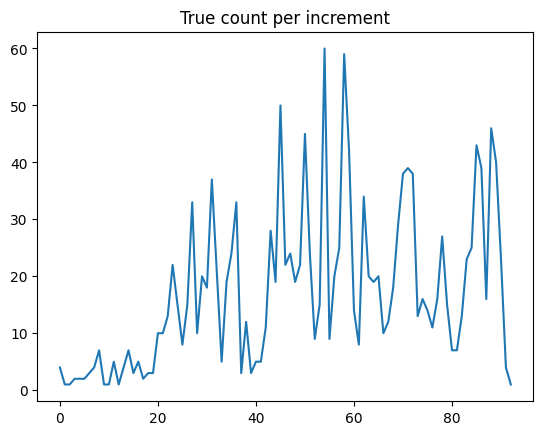

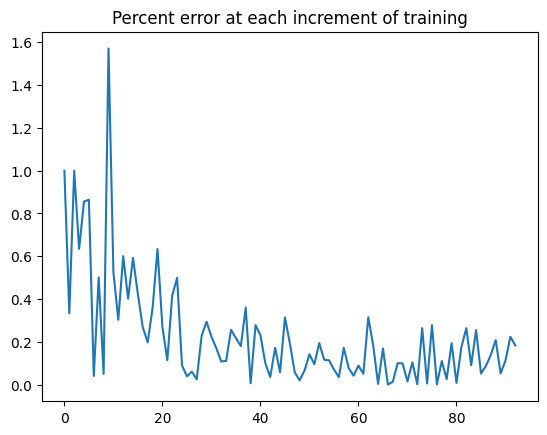

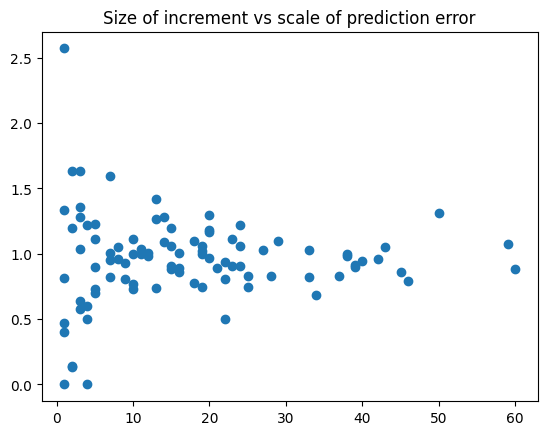

In [73]:
import matplotlib.pyplot as plt

errs = inc_pred - inc_true
yhat_perf = abs(errs/(inc_true))

plt.plot(inc_true)
plt.title('True count per increment')
plt.show()
plt.plot(yhat_perf)
plt.title('Percent error at each increment of training')
plt.show()
plt.scatter(inc_true, inc_pred/inc_true)
plt.title('Size of increment vs scale of prediction error')
plt.show()

Estimated asymptote (convergence value) at i,j (5,0): 0.10216084282866826
Estimated asymptote (convergence value) at i,j (5,1): 0.0999880179845353
Estimated asymptote (convergence value) at i,j (5,2): 0.10992708940844417
Estimated asymptote (convergence value) at i,j (5,3): 0.11700167638606242
Estimated asymptote (convergence value) at i,j (5,4): 0.11702021464424171
Estimated asymptote (convergence value) at i,j (6,0): 0.12665854038558455
Estimated asymptote (convergence value) at i,j (6,1): 0.12894700409542134
Estimated asymptote (convergence value) at i,j (6,2): 0.10774037068017274
Estimated asymptote (convergence value) at i,j (6,3): 0.10622421599880674
Estimated asymptote (convergence value) at i,j (6,4): 0.10440416073974838
Estimated asymptote (convergence value) at i,j (7,0): 0.11365062592787335
Estimated asymptote (convergence value) at i,j (7,1): 0.12001764023653376
Estimated asymptote (convergence value) at i,j (7,2): 0.10719651520855177
Estimated asymptote (convergence value)

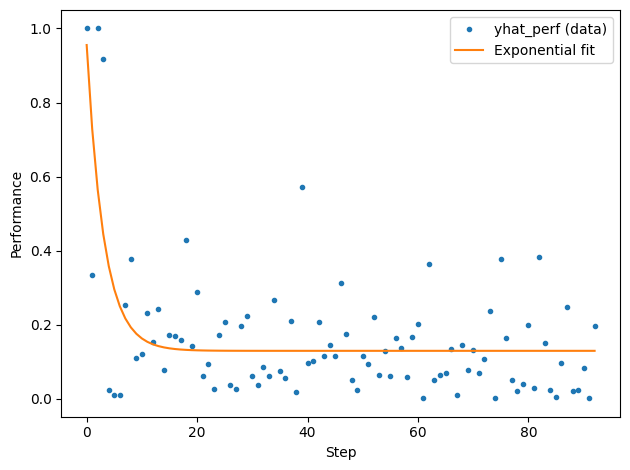

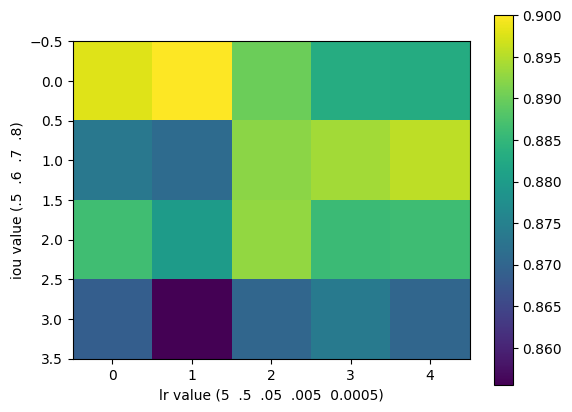

In [110]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def exp_conv(t, L_, A, k):
    return L_ + A * np.exp(-k * t)


import numpy as np
import dill as pickle

mat_L = np.ones((5, 5), dtype=np.float32)

for i in range(5,9):
    for j in range(0, 5):
        with open('bb_iou_'+str(i)+'0.pkl', 'rb') as file:
            tmp_load = pickle.load(file)
            trainer, event_tuple, report, metrics = tmp_load

        inc_pred, cum_pred, metrics = walk_forward_eval(event_tuple[0], event_tuple[1], report['frame_index'].values, report['cum_true'].values, 
            TrainerCtor=lambda: GroupedSoftplusSGDVector(lr=(5 / 10 ** j), epochs=(10 if j>0 else 1), l2=5e-3, clip=2.0,
            report_every=50, early_stop_patience=50),
            verbose=False)

        inc_true = report['inc_true'].values
        cum_true = np.cumsum(inc_true)

        errs = inc_pred - inc_true
        yhat_perf = abs(errs/(inc_true))

        L = len(yhat_perf)
        t = np.arange(L, dtype=float)


        # 3. Rough initial guesses
        L0 = yhat_perf[-1]                      # asymptote ~ last value
        A0 = yhat_perf[0] - yhat_perf[-1]       # initial offset
        k0 = 0.1                                # some positive rate

        p0 = [L0, A0, k0]

        params, _ = curve_fit(exp_conv, t, yhat_perf, p0=p0, maxfev=10000)
        L_hat, A_hat, k_hat = params

        y_fit = exp_conv(t, L_hat, A_hat, k_hat)

        mat_L[i-5,j] = L_hat

        print(f"Estimated asymptote (convergence value) at i,j ({i},{j}):", L_hat)

        if(L_hat<0):
            plt.plot(yhat_perf)
            plt.title(f'Error yhat_perf printout at i,j of ({i},{j})')
            plt.show()
        #print("Estimated A:", A_hat)
        #print("Estimated k:", k_hat)

# 6. Plot original vs fitted
plt.figure()
plt.plot(t, yhat_perf, 'o', label='yhat_perf (data)', markersize=3)
plt.plot(t, y_fit, '-', label='Exponential fit')
plt.xlabel('Step')
plt.ylabel('Performance')
plt.legend()
plt.tight_layout()
plt.show()

mat_L_inv = 1- mat_L
plt.imshow(mat_L_inv[:4,:])
plt.colorbar()
plt.xlabel('lr value (5  .5  .05  .005  0.0005)')
plt.ylabel('iou value (.5  .6  .7  .8)')
plt.show()

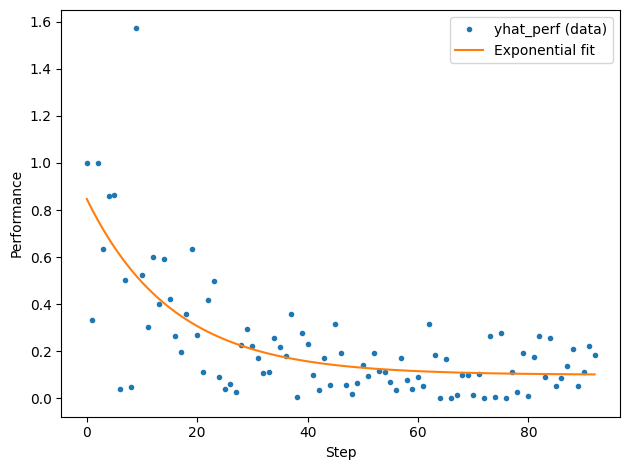

Estimated asymptote (convergence value) at i,j (8,4): 0.0999880179845353


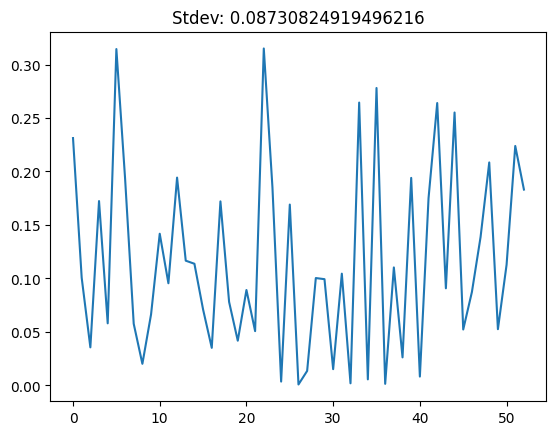

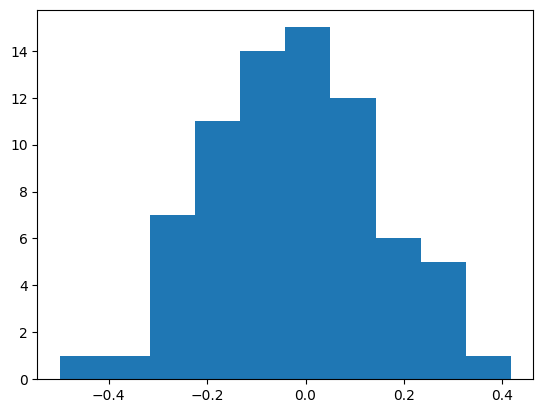

In [126]:
with open('bb_iou_'+str(5)+'0.pkl', 'rb') as file:
    tmp_load = pickle.load(file)
    trainer, event_tuple, report, metrics = tmp_load

inc_pred, cum_pred, metrics = walk_forward_eval(event_tuple[0], event_tuple[1], report['frame_index'].values, report['cum_true'].values, 
            TrainerCtor=lambda: GroupedSoftplusSGDVector(lr=(5 / 10 ** 1), epochs=(10), l2=5e-3, clip=2.0,
            report_every=50, early_stop_patience=50),
            verbose=False)

inc_true = report['inc_true'].values
cum_true = np.cumsum(inc_true)

errs = inc_pred - inc_true
yhat_perf = abs(errs/(inc_true))

L = len(yhat_perf)
t = np.arange(L, dtype=float)


        # 3. Rough initial guesses
L0 = yhat_perf[-1]                      # asymptote ~ last value
A0 = yhat_perf[0] - yhat_perf[-1]       # initial offset
k0 = 0.1                                # some positive rate

p0 = [L0, A0, k0]

params, _ = curve_fit(exp_conv, t, yhat_perf, p0=p0, maxfev=10000)
L_hat, A_hat, k_hat = params

y_fit = exp_conv(t, L_hat, A_hat, k_hat)

plt.figure()
plt.plot(t, yhat_perf, 'o', label='yhat_perf (data)', markersize=3)
plt.plot(t, y_fit, '-', label='Exponential fit')
plt.xlabel('Step')
plt.ylabel('Performance')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Estimated asymptote (convergence value) at i,j ({i},{j}):", L_hat)

static_yhat = yhat_perf[40:]
stdev_static = np.std(static_yhat)

plt.plot(static_yhat)
plt.title(f'Stdev: {stdev_static}')
plt.show()

plt.hist(((inc_pred-inc_true)/inc_true)[20:])
plt.show()


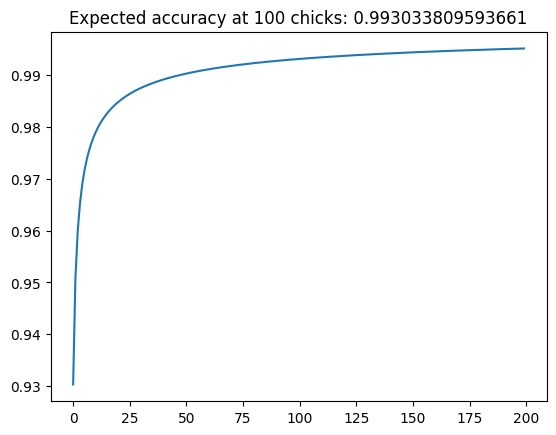

0.9982584523984153
0.99813200498132


In [131]:
def exp_abs_dev_at_t(t):
    return 1-(np.sqrt(2/np.pi) * stdev_static / np.sqrt(t))

N = 200
t = np.arange(1, N + 1, dtype=float)   # 1, 2, ..., N
y = exp_abs_dev_at_t(t)                # shape (N,)

plt.plot(y)
plt.title(f'Expected accuracy at 100 chicks: {exp_abs_dev_at_t(100)}')
plt.show()

print(exp_abs_dev_at_t(1600))
print(1603/1606)